In [1]:
# conda install tensorflow-gpu==2.1.0 matplotlib
# pip install sciann
# sciann version: 0.6.3.1
import pathlib
import numpy as np
import time
import sciann as sn
from sciann_datagenerator import DataGeneratorXY
from sciann.utils.math import diff
import tensorflow.keras.callbacks as callbacks
from scipy.special import hankel1
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


In [2]:
def data_tmp(start=-2, end=8, num=50000, amp=1.0, sz=0.0, sr=0.0):
    dg = DataGeneratorXY(
        X=[start, end],
        Y=[start, end],
        targets=["domain"],
        num_sample=num,
    )
    dg.plot_sample_batch(batch_size=1024)
    xx = np.squeeze(dg.input_data[0])
    yy = np.squeeze(dg.input_data[1])
    rr = np.sqrt((xx-sr)**2 + (yy-sz)**2)

    # Green(x,y) = Hankel_0^1(k * r)
    freq = 50.0
    Pi = 3.141592653

    omega = 2 * Pi * freq
    m0 = 1/1500.0
    m1 = 1/1450.0
    k0 = omega * m0
    k1 = omega * m1
    u0_real = np.real(amp * hankel1(0, k1*rr))
    u0_imag = np.imag(amp * hankel1(0, k1*rr))

    G0_real = np.real(amp * hankel1(0, k0*rr))
    G0_imag = np.imag(amp * hankel1(0, k0*rr))

    # # complex valued part is phase shifted by 90°
    # k_out = k0 * np.ones(u0_real.shape)

    dp_real = u0_real - G0_real
    dp_imag = u0_imag - G0_imag
    return xx, yy, dp_real, dp_imag, omega, G0_real, G0_imag, m0, m1

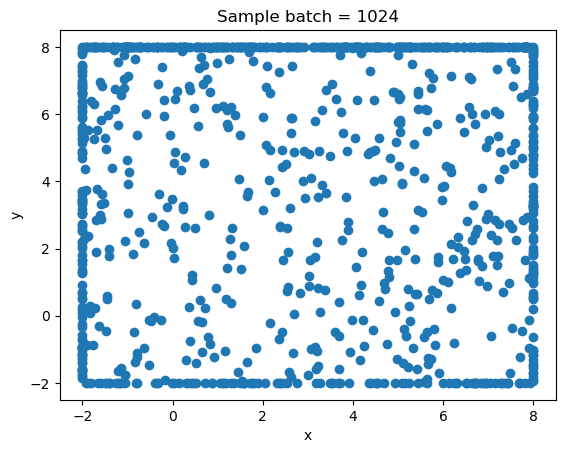

In [3]:
if __name__ == "__main__":
    # prepare data
    r_data, z_data, p_real_data, p_imag_data, omega, G_real_data, G_imag_data, m0, m1 = data_tmp(num=10000)
#     isTrain = True
    isTrain = False
    k0_data = omega * m0 * np.ones(r_data.shape)
    k1_data = omega * m1 * np.ones(r_data.shape)

    # Variable and Fields
    r = sn.Variable("r", dtype='float64')
    z = sn.Variable("z", dtype='float64')
    k0 = sn.Variable("k0", dtype='float64')
    k1 = sn.Variable("k1", dtype='float64')
    G_real = sn.Variable("G_real", dtype='float64')
    G_imag = sn.Variable("G_imag", dtype='float64')

    p_real = sn.Functional("p_real", [r, z, k0, k1, G_real], 4*[20], "sin")
    p_imag = sn.Functional("p_imag", [r, z, k0, k1, G_imag], 4*[20], "sin")

    # pde ($\Delta p + k^2 \cdot p = 0$) split into real- and complex-valued part
    laplace_Re_dp = diff(p_real, r, order=2) + diff(p_real, z, order=2)
    laplace_Im_dp = diff(p_imag, r, order=2) + diff(p_imag, z, order=2)

    L1 = laplace_Re_dp + k1**2 * p_real + (k1**2 - k0**2)*G_real
    L2 = laplace_Im_dp + k1**2 * p_imag + (k1**2 - k0**2)*G_imag
    c1 = sn.Data(p_real)
    c2 = sn.Data(p_imag)

    # model and input
    input = [r, z, k0, k1, G_real, G_imag]
    input_value = [r_data, z_data, k0_data, k1_data, G_real_data, G_imag_data]
    target = [sn.PDE(L1), sn.PDE(L2), c1, c2]
    target_value = ['zeros', 'zeros', p_real_data, p_imag_data]
    model = sn.SciModel(
        input,
        target)
#         optimizer='scipy-l-BFGS-B')
#         load_weights_from='model/2D_dp_[0,100]x[0,100]_zs[0,0]_Gc1.5.hdf5',
#         optimizer='scipy-l-BFGS-B')

    # callbacks
    current_path = os.path.abspath('')
    checkpoint_filepath = str(os.path.join(current_path,'callbacks/N2Green/N2Green_dp.ckpt'))
    save_path = str(os.path.join(current_path,'model/2D_dp_WEIGHT.hdf5'))
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='auto',
        save_best_only=True
    )
    if isTrain:
        t = time.time()
        history = model.train(
            input_value,
            target_value,
            epochs=1500,
            batch_size=400,
            adaptive_weights={"method": "NTK", "freq": 100},
            # callbacks=[model_checkpoint_callback],
            shuffle=True,
            learning_rate=0.001,
            reduce_lr_after=100,
            stop_loss_value=1e-8
        )
        t = time.time() - t
        #
        model.save_weights(save_path)
        fig, ax = plt.subplots(1, 1, figsize=(7,3), dpi=80)
        loss1 = history.history['p_real_loss']
        loss2 = history.history['p_imag_loss']
        time_step = np.linspace(0, t, len(history.history["p_real_loss"]))
        print(time_step.shape)
        plt.plot(history.history['p_real_loss'] / loss1[0], 'r', label='$p_{real}$-loss')
        plt.plot(history.history['p_imag_loss'] / loss2[0], 'b', label='$p_{imag}$-loss')
        plt.yscale('log')
        plt.xlabel('epoch')
        plt.ylabel('Mean-Squared-Error')
        plt.title('Loss')
        plt.legend()
        plt.show()
    else:
        model.load_weights(save_path)

In [4]:
    # predictions
    N = 1000
    x_max = 8
    y_max = 8
    x_min = -2
    y_min = -2
    xx = np.linspace(x_min, x_max, N)
    yy = np.linspace(y_min, y_max, N)
    sx = 0
    sy = 0

    x_test, y_test = np.meshgrid(xx, yy)
    x_eval = x_test.flatten()
    y_eval = y_test.flatten()
    r_eval = np.sqrt((x_eval-sx)**2 + (y_eval-sy)**2)
    k0 = k0_data[0]
    k1 = k1_data[0]
    k0_test = k0 * np.ones(x_eval.shape)
    k1_test = k1 * np.ones(x_eval.shape)
    G_real_test = np.real(hankel1(0, k0*r_eval))
    G_imag_test = np.imag(hankel1(0, k0*r_eval))

    ps_real_pred = p_real.eval(model, [x_eval, y_eval, k0_test, k1_test, G_real_test, G_imag_test])
    ps_imag_pred = p_imag.eval(model, [x_eval, y_eval, k0_test, k1_test, G_real_test, G_imag_test])

    p_real_pred = (ps_real_pred + G_real_test).reshape(x_test.shape)
    p_imag_pred = (ps_imag_pred + G_imag_test).reshape(x_test.shape)
    ps_real_pred = ps_real_pred.reshape(x_test.shape)
    ps_imag_pred = ps_imag_pred.reshape(x_test.shape)
    k1_test = k1_test.reshape(x_test.shape)

    # exact solution
    p_real_exsol = np.real(hankel1(0, k1_test * np.sqrt((x_test-sx) ** 2 + (y_test-sy) ** 2)))
    p_imag_exsol = np.imag(hankel1(0, k1_test * np.sqrt((x_test-sx) ** 2 + (y_test-sy) ** 2)))
    print(k1_test.shape, x_test.shape, y_test.shape, p_real_exsol.shape)
    k0_test = k0_test.reshape(x_test.shape)
    ps_real_exsol = p_real_exsol-np.real(hankel1(0, k0_test*np.sqrt((x_test-sx)**2+(y_test-sy)**2)))
    ps_imag_exsol = p_imag_exsol-np.imag(hankel1(0, k0_test*np.sqrt((x_test-sx)**2+(y_test-sy)**2)))

    # pre2tl
    pr_exsol = (p_real_exsol / np.real(hankel1(0, k1_test))) ** 2
    pi_exsol = (p_imag_exsol / np.imag(hankel1(0, k1_test))) ** 2
    tl_exsol = -20 * np.log10(np.sqrt(pr_exsol + pi_exsol))
    prs_exsol = (ps_real_exsol / np.real(hankel1(0, k1_test))) ** 2
    pis_exsol = (ps_imag_exsol / np.imag(hankel1(0, k1_test))) ** 2
    tls_exsol = -20 * np.log10(np.sqrt(prs_exsol + pis_exsol))
    
    pr_pred = (p_real_pred / np.real(hankel1(0, k1_test))) ** 2
    pi_pred = (p_imag_pred / np.imag(hankel1(0, k1_test))) ** 2
    prs_pred = (ps_real_pred / np.real(hankel1(0, k1_test))) ** 2
    pis_pred = (ps_imag_pred / np.imag(hankel1(0, k1_test))) ** 2
    tl_pred = -20 * np.log10(np.sqrt(pr_pred + pi_pred))
    tls_pred = -20 * np.log10(np.sqrt(prs_pred + pis_pred))

(1000, 1000) (1000, 1000) (1000, 1000) (1000, 1000)


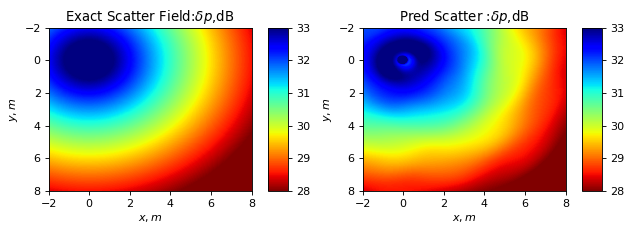

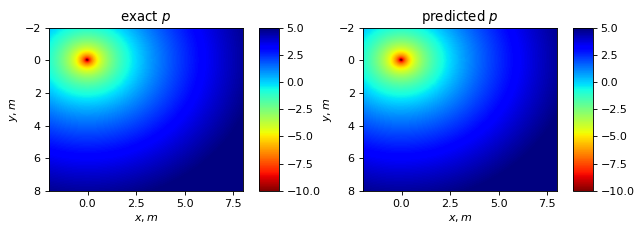

In [14]:
    # pressure
#     fig = plt.figure(1, figsize=(8, 6), dpi=80)
#     ax = plt.subplot(2, 2, 1)
#     ax.invert_yaxis()
#     h0 = ax.pcolormesh(xx, yy, p_real_exsol, cmap='jet_r', shading='auto', vmin=0, vmax=1)
#     divider = make_axes_locatable(ax)
#     cax1 = divider.append_axes("right", size="5%", pad=0.2)
#     fig.colorbar(h0, cax=cax1)
#     ax.set_xlabel('$x, m$')
#     ax.set_ylabel('$y, m$')
#     ax.set_title('exact solution')

#     ax = plt.subplot(2, 2, 2)
#     ax.invert_yaxis()
#     h2 = ax.pcolormesh(xx, yy, p_real_pred, cmap='jet_r', shading='auto', vmin=0, vmax=1)
#     divider = make_axes_locatable(ax)
#     cax3 = divider.append_axes("right", size="5%", pad=0.2)
#     fig.colorbar(h2, cax=cax3)
#     ax.set_xlabel('$x, m$')
#     ax.set_ylabel('$y, m$')
#     ax.set_title('predicted solution')
#     plt.tight_layout()
    
#     ax = plt.subplot(2, 2, 3)
#     ax.invert_yaxis()
#     h1 = ax.pcolormesh(xx, yy, p_imag_exsol, cmap='jet_r', shading='auto', vmin=-5, vmax=1)
#     divider = make_axes_locatable(ax)
#     cax2 = divider.append_axes("right", size="5%", pad=0.2)
#     fig.colorbar(h1, cax=cax2)
#     ax.set_xlabel('$x, m$')
#     ax.set_ylabel('$y, m$')
#     ax.set_title('exact solution')

#     ax = plt.subplot(2, 2, 4)
#     ax.invert_yaxis()
#     h3 = ax.pcolormesh(xx, yy, p_imag_pred, cmap='jet_r', shading='auto', vmin=-5, vmax=1)
#     divider = make_axes_locatable(ax)
#     cax4 = divider.append_axes("right", size="5%", pad=0.2)
#     fig.colorbar(h3, cax=cax4)
#     ax.set_xlabel('$x, m$')
#     ax.set_ylabel('$y, m$')
#     ax.set_title('predicted solution')
#     plt.tight_layout()
#     plt.show()
    fig = plt.figure(2, figsize=(8,3), dpi=80)
    ax = plt.subplot(1, 2, 1)
    ax.invert_yaxis()
    h1=ax.pcolormesh(xx, yy, tls_exsol, cmap='jet_r', shading='auto', vmin=28, vmax=33)
    divider = make_axes_locatable(ax)
    cax2 = divider.append_axes("right", size="10%", pad=0.2)
    fig.colorbar(h1, cax=cax2)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('Exact Scatter Field:$\delta p$,dB')
    ax = plt.subplot(1, 2, 2)
    ax.invert_yaxis()
    h3 = ax.pcolormesh(xx, yy, tls_pred, cmap='jet_r', shading='auto', vmin=28, vmax=33)
    divider = make_axes_locatable(ax)
    cax4 = divider.append_axes("right", size="10%", pad=0.2)
    fig.colorbar(h3, cax=cax4)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('Pred Scatter :$\delta p$,dB')
    plt.tight_layout()
    plt.savefig('./figures/scatterdP.png',dpi=300)
    plt.show()
    
    fig = plt.figure(3, figsize=(8, 3), dpi=80)
    ax = plt.subplot(1, 2, 1)
    ax.invert_yaxis()
    h1 = ax.pcolormesh(xx, yy, tl_exsol, cmap='jet_r', shading='auto', vmin=-10, vmax=5)
    divider = make_axes_locatable(ax)
    cax2 = divider.append_axes("right", size="10%", pad=0.2)
    fig.colorbar(h1, cax=cax2)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('exact $p$')

    ax = plt.subplot(1, 2, 2)
    ax.invert_yaxis()
    h3 = ax.pcolormesh(xx, yy, tl_pred, cmap='jet_r', shading='auto', vmin=-10, vmax=5)
    divider = make_axes_locatable(ax)
    cax4 = divider.append_axes("right", size="10%", pad=0.2)
    fig.colorbar(h3, cax=cax4)
    ax.set_xlabel('$x, m$')
    ax.set_ylabel('$y, m$')
    ax.set_title('predicted $p$')
    plt.tight_layout()
    plt.savefig('./figures/scatterP.png',dpi=300)
    plt.show()

50


C:\Users\51158\.conda\envs\sciNNproject\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\51158\.conda\envs\sciNNproject\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\51158\.conda\envs\sciNNproject\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Addi

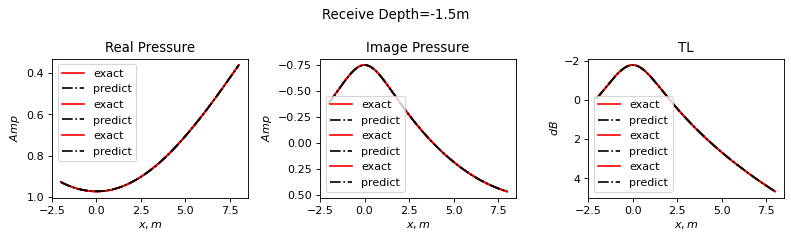

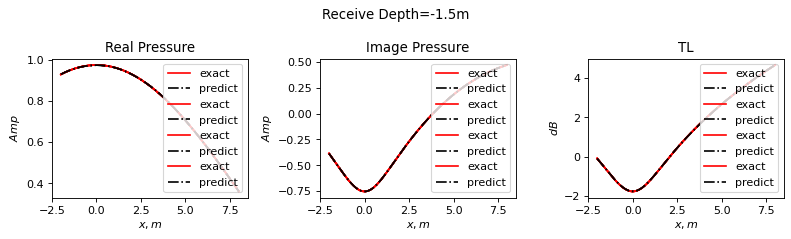

100


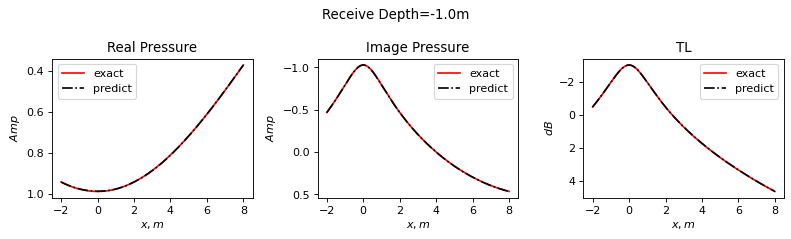

200


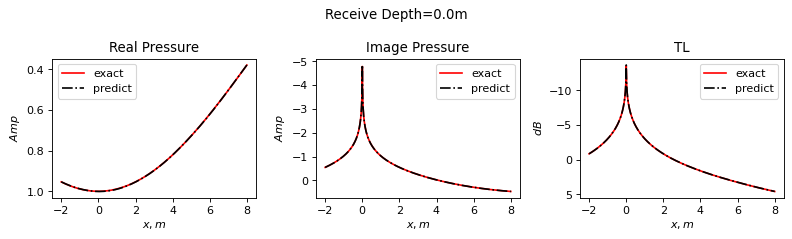

450


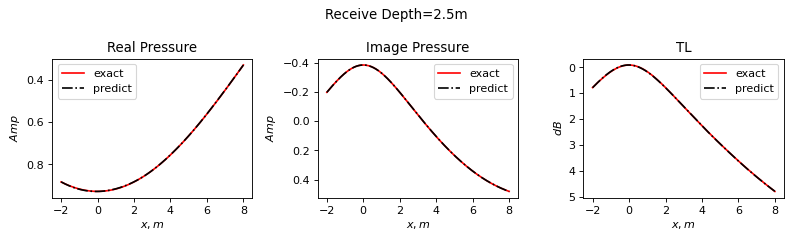

In [13]:

    dx = (x_max - x_min) / N
    dy = (y_max - y_min) / N
#     zy = 3
#     ny = int(zy / dy)
    ax = 5
    def plot_line(ny, ax):
        zy = ny * dy
        print(ny)
        fig = plt.figure(ax, figsize=(10, 3), dpi=80)
        plt.suptitle('Receive Depth='+str(zy+y_min)+'m')
        ax = plt.subplot(1, 3, 1)
        ax.invert_yaxis()
        h6 = ax.plot(xx, p_real_exsol[ny, :], 'r', linewidth=1.5, label='exact')
        h7 = ax.plot(xx, p_real_pred[ny, :], 'k-.', linewidth=1.5, label='predict')
        ax.set_xlabel('$x, m$')
        ax.set_ylabel('$Amp$')
        ax.set_title('Real Pressure')
        plt.legend()

        ax = plt.subplot(1, 3, 2)
        ax.invert_yaxis()
        h8 = ax.plot(xx, p_imag_exsol[ny, :], 'r', linewidth=1.5, label='exact')
        h9 = ax.plot(xx, p_imag_pred[ny, :], 'k-.', linewidth=1.5, label='predict')
        ax.set_xlabel('$x, m$')
        ax.set_ylabel('$Amp$')
        ax.set_title('Image Pressure')
        plt.legend()
        plt.tight_layout()

        ax = plt.subplot(1, 3, 3)
        ax.invert_yaxis()
        h10 = ax.plot(xx, tl_exsol[ny, :], 'r', linewidth=1.5, label='exact')
        h11 = ax.plot(xx, tl_pred[ny, :], 'k-.', linewidth=1.5, label='predict')
        ax.set_xlabel('$x, m$')
        ax.set_ylabel('$dB$')
        ax.set_title('TL')
        plt.legend()
        plt.savefig('./figures/PinLine'+str(ax)+'.png',dpi=300)
        plt.tight_layout()
        plt.show()
    plot_line(int((-1.5 - y_min)/dy), 1)
    plot_line(int((-1 - y_min)/dy), 2)
    plot_line(int((+0 - y_min)/dy), 3)
    plot_line(int((+2.5 - y_min)/dy), 4)